In [1]:
import torch
import tqdm
import matplotlib.pyplot as plt
from utils import display_img, process
from latent_dataset import WPlusLatentsDataset
from SAE import SparseAutoencoder
from torch.utils.data import DataLoader
from evaluate_saes import test_reconstructions
import einops

In [2]:
device = 'mps'

In [3]:
TRAIN_PATH = '/Users/spra/Desktop/Personal Projects/CV_final_project/G_w_train_latents'
train_data = WPlusLatentsDataset(TRAIN_PATH)
train_loader = DataLoader(train_data, batch_size = 64, shuffle = True)

VAL_PATH = '/Users/spra/Desktop/Personal Projects/CV_final_project/G_w_val_latents'
val_data = WPlusLatentsDataset(VAL_PATH)
val_loader = DataLoader(val_data, batch_size = 64, shuffle = True)

In [4]:
SAE = SparseAutoencoder(latent_dim = 512, hidden_dim = 1024, sparsity_lambda = 0.2, device = device).to(device)

In [5]:
def train_sae_epoch(sae, loader, optimizer):
    total_losses = []
    reconstruction_losses = []
    sparsity_losses = []
    for batch in tqdm.tqdm(loader):
        optimizer.zero_grad()
        batch = batch.to(sae.device)
        reconstructions, latents = sae(batch)
        total_loss, reconstruction_loss, sparsity_loss = sae.loss(batch, reconstructions, latents)
        total_loss.backward()
        optimizer.step()
        total_losses.append(total_loss.item())
        reconstruction_losses.append(reconstruction_loss.item())
        sparsity_losses.append(sparsity_loss.item())
    return total_losses, reconstruction_losses, sparsity_losses

def train_sae(sae, train_loader, val_loader, optimizer, num_epochs, resampling_epochs):
    all_total_losses = []
    all_reconstruction_losses = []
    all_sparsity_losses = []
    eval_losses = []
    eval_recon_losses = []
    eval_sparsity_losses = []
    for i in range(num_epochs):
        print(f'Starting epoch {i}!')
        total_losses, reconstruction_losses, sparsity_losses = train_sae_epoch(sae, train_loader, optimizer)
        all_total_losses.extend(total_losses)
        all_reconstruction_losses.extend(reconstruction_losses)
        all_sparsity_losses.extend(sparsity_losses)
        if i in resampling_epochs:
            batch = next(iter(train_loader))
            with torch.no_grad():
                reconstructions, latents = sae(batch)
            sae.resample_dead_features(batch, latents, activation_threshold = 1e-4)
        avg_total_loss, avg_recon_loss, avg_sparsity_loss = evaluate(SAE, val_loader)
        eval_losses.append(avg_total_loss)
        eval_recon_losses.append(avg_recon_loss)
        eval_sparsity_losses.append(avg_sparsity_loss)
        print(f'Evaluation loss: {avg_total_loss}, Reconstruction loss: {avg_recon_loss}, Sparsity Loss: {avg_sparsity_loss}')
        print('\n')
    return all_total_losses, all_reconstruction_losses, all_sparsity_losses, eval_losses, eval_recon_losses, eval_sparsity_losses

@torch.inference_mode()
def evaluate(sae, loader):
    all_total_losses = []
    all_reconstruction_losses = []
    all_sparsity_losses = []
    for batch in tqdm.tqdm(loader):
        reconstructions, latents = sae(batch)
        total_loss, reconstruction_loss, sparsity_loss = sae.loss(batch, reconstructions, latents)
        all_total_losses.append(total_loss.item())
        all_reconstruction_losses.append(reconstruction_loss.item())
        all_sparsity_losses.append(sparsity_loss.item())
    avg_total_loss = sum(all_total_losses) / len(all_total_losses)
    avg_recon_loss = sum(all_reconstruction_losses) / len(all_reconstruction_losses)
    avg_sparsity_loss = sum(all_sparsity_losses) / len(all_sparsity_losses)
    return avg_total_loss, avg_recon_loss, avg_sparsity_loss

In [6]:
optimizer = torch.optim.Adam(params = SAE.parameters(), lr = 1e-3)

In [7]:
all_total_losses, all_reconstruction_losses, all_sparsity_losses, eval_losses, eval_recon_losses, eval_sparsity_losses = train_sae(SAE, train_loader, val_loader, optimizer, 30, {5, 6, 7, 8, 9, 10, 11, 12})

Starting epoch 0!


100%|██████████| 32/32 [00:03<00:00,  8.12it/s]


Evaluation loss: 0.05063152278307825, Reconstruction loss: 0.020755975099746138, Sparsity Loss: 0.1493777371942997


Starting epoch 1!


100%|██████████| 32/32 [00:03<00:00,  8.30it/s]


Evaluation loss: 0.04206798190716654, Reconstruction loss: 0.017363918013870716, Sparsity Loss: 0.12352031841874123


Starting epoch 2!


100%|██████████| 32/32 [00:03<00:00,  8.29it/s]


Evaluation loss: 0.037944097886793315, Reconstruction loss: 0.014787760912440717, Sparsity Loss: 0.11578168254345655


Starting epoch 3!


100%|██████████| 32/32 [00:03<00:00,  8.29it/s]


Evaluation loss: 0.03538434684742242, Reconstruction loss: 0.01300601934781298, Sparsity Loss: 0.111891636159271


Starting epoch 4!


100%|██████████| 32/32 [00:03<00:00,  8.35it/s]


Evaluation loss: 0.033269286155700684, Reconstruction loss: 0.01144910091534257, Sparsity Loss: 0.10910092573612928


Starting epoch 5!


100%|██████████| 157/157 [00:19<00:00,  7.90it/s]


None Resampled!


100%|██████████| 32/32 [00:03<00:00,  8.22it/s]


Evaluation loss: 0.03150521032512188, Reconstruction loss: 0.010078043269459158, Sparsity Loss: 0.10713583556935191


Starting epoch 6!


100%|██████████| 157/157 [00:19<00:00,  7.95it/s]


1 resampled!


100%|██████████| 32/32 [00:03<00:00,  8.20it/s]


Evaluation loss: 0.04928338772151619, Reconstruction loss: 0.02762237162096426, Sparsity Loss: 0.10830508195795119


Starting epoch 7!


100%|██████████| 157/157 [00:19<00:00,  7.87it/s]


7 resampled!


100%|██████████| 32/32 [00:03<00:00,  8.30it/s]


Evaluation loss: 0.3559871492907405, Reconstruction loss: 0.331075101159513, Sparsity Loss: 0.12456024251878262


Starting epoch 8!


100%|██████████| 157/157 [00:19<00:00,  7.93it/s]


133 resampled!


100%|██████████| 32/32 [00:03<00:00,  8.25it/s]


Evaluation loss: 69.40619468688965, Reconstruction loss: 69.3149049282074, Sparsity Loss: 0.45645392034202814


Starting epoch 9!


100%|██████████| 157/157 [00:19<00:00,  7.98it/s]


549 resampled!


100%|██████████| 32/32 [00:03<00:00,  8.21it/s]


Evaluation loss: 1110.783790588379, Reconstruction loss: 1110.484390258789, Sparsity Loss: 1.4969908446073532


Starting epoch 10!


100%|██████████| 157/157 [00:20<00:00,  7.81it/s]


185 resampled!


100%|██████████| 32/32 [00:03<00:00,  8.33it/s]


Evaluation loss: 121.43056154251099, Reconstruction loss: 121.32901859283447, Sparsity Loss: 0.5077167544513941


Starting epoch 11!


100%|██████████| 157/157 [00:19<00:00,  7.91it/s]


26 resampled!


100%|██████████| 32/32 [00:03<00:00,  8.29it/s]


Evaluation loss: 2.4665826335549355, Reconstruction loss: 2.4474844858050346, Sparsity Loss: 0.09549076855182648


Starting epoch 12!


100%|██████████| 157/157 [00:20<00:00,  7.84it/s]


8 resampled!


100%|██████████| 32/32 [00:03<00:00,  8.29it/s]


Evaluation loss: 0.6170729752629995, Reconstruction loss: 0.6037367843091488, Sparsity Loss: 0.06668094173073769


Starting epoch 13!


100%|██████████| 32/32 [00:04<00:00,  7.76it/s]


Evaluation loss: 0.10585380624979734, Reconstruction loss: 0.09594168304465711, Sparsity Loss: 0.04956061590928584


Starting epoch 14!


100%|██████████| 32/32 [00:03<00:00,  8.66it/s]


Evaluation loss: 0.09719849051907659, Reconstruction loss: 0.08669999637641013, Sparsity Loss: 0.052492470713332295


Starting epoch 15!


100%|██████████| 32/32 [00:03<00:00,  8.63it/s]


Evaluation loss: 0.09168601944111288, Reconstruction loss: 0.08078365842811763, Sparsity Loss: 0.054511804482899606


Starting epoch 16!


100%|██████████| 32/32 [00:03<00:00,  8.88it/s]


Evaluation loss: 0.08736690762452781, Reconstruction loss: 0.0760836317203939, Sparsity Loss: 0.05641638080123812


Starting epoch 17!


100%|██████████| 32/32 [00:03<00:00,  8.02it/s]


Evaluation loss: 0.08399751293472946, Reconstruction loss: 0.07241917937062681, Sparsity Loss: 0.05789166910108179


Starting epoch 18!


100%|██████████| 32/32 [00:03<00:00,  8.81it/s]


Evaluation loss: 0.08104559313505888, Reconstruction loss: 0.06919300090521574, Sparsity Loss: 0.05926295917015523


Starting epoch 19!


100%|██████████| 32/32 [00:03<00:00,  8.59it/s]


Evaluation loss: 0.07863513985648751, Reconstruction loss: 0.06656137527897954, Sparsity Loss: 0.060368824284523726


Starting epoch 20!


100%|██████████| 32/32 [00:04<00:00,  7.90it/s]


Evaluation loss: 0.07663424639031291, Reconstruction loss: 0.06439232476986945, Sparsity Loss: 0.061209608684293926


Starting epoch 21!


100%|██████████| 32/32 [00:03<00:00,  8.91it/s]


Evaluation loss: 0.07489518448710442, Reconstruction loss: 0.06251789093948901, Sparsity Loss: 0.06188646669033915


Starting epoch 22!


100%|██████████| 32/32 [00:03<00:00,  8.75it/s]


Evaluation loss: 0.07323086471296847, Reconstruction loss: 0.060712104314006865, Sparsity Loss: 0.06259380036499351


Starting epoch 23!


100%|██████████| 32/32 [00:03<00:00,  8.72it/s]


Evaluation loss: 0.07169341645203531, Reconstruction loss: 0.05904474179260433, Sparsity Loss: 0.06324337399564683


Starting epoch 24!


100%|██████████| 32/32 [00:03<00:00,  8.74it/s]


Evaluation loss: 0.07038875785656273, Reconstruction loss: 0.057606758549809456, Sparsity Loss: 0.06390999909490347


Starting epoch 25!


100%|██████████| 32/32 [00:03<00:00,  8.59it/s]


Evaluation loss: 0.06912426953203976, Reconstruction loss: 0.056230543879792094, Sparsity Loss: 0.06446863012388349


Starting epoch 26!


100%|██████████| 32/32 [00:03<00:00,  8.86it/s]


Evaluation loss: 0.06795221846550703, Reconstruction loss: 0.05493066390044987, Sparsity Loss: 0.0651077690999955


Starting epoch 27!


100%|██████████| 32/32 [00:03<00:00,  8.74it/s]


Evaluation loss: 0.06696496438235044, Reconstruction loss: 0.05385873350314796, Sparsity Loss: 0.06553115649148822


Starting epoch 28!


100%|██████████| 32/32 [00:03<00:00,  8.77it/s]


Evaluation loss: 0.06605212995782495, Reconstruction loss: 0.05287674127612263, Sparsity Loss: 0.06587693933397532


Starting epoch 29!


100%|██████████| 32/32 [00:03<00:00,  8.78it/s]

Evaluation loss: 0.065141691127792, Reconstruction loss: 0.0518569303676486, Sparsity Loss: 0.06642380496487021




In [9]:
total_losses, reconstruction_losses, sparsity_losses = torch.tensor(all_total_losses), torch.tensor(all_reconstruction_losses), torch.tensor(all_sparsity_losses)

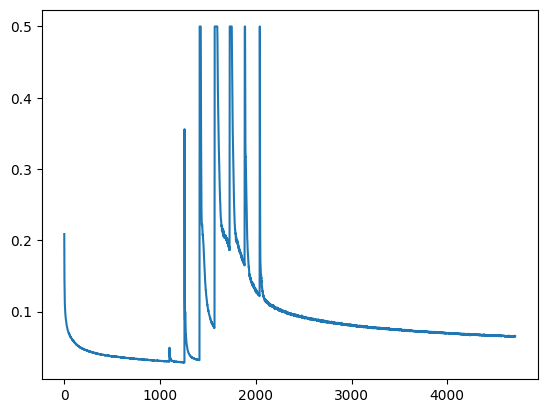

In [10]:
plt.plot(torch.clamp(total_losses, 0, 0.5))
plt.show()

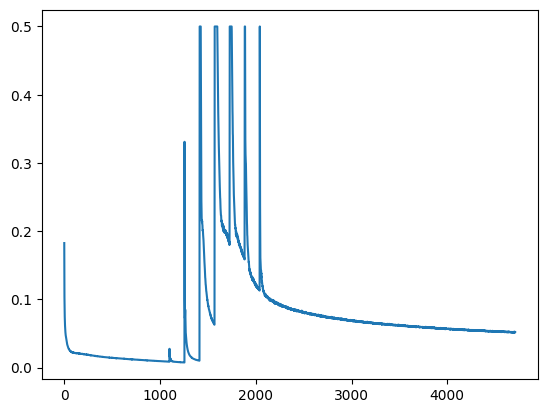

In [11]:
plt.plot(torch.clamp(reconstruction_losses, 0, 0.5))
plt.show()

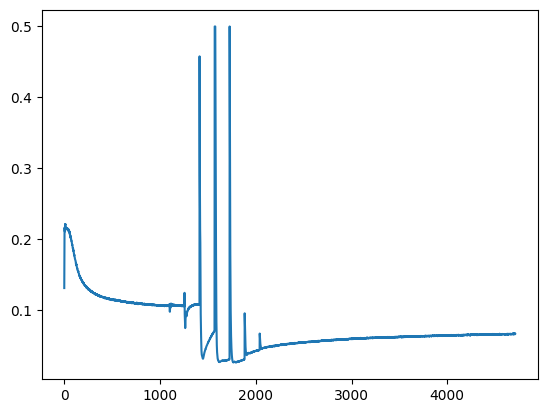

In [12]:
plt.plot(torch.clamp(sparsity_losses, 0, 0.5))
plt.show()

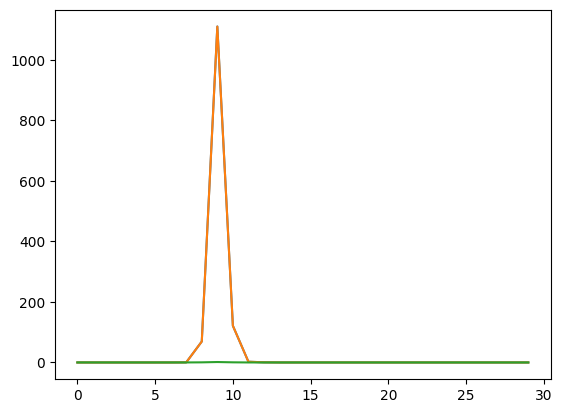

In [13]:
plt.plot(eval_losses, label = 'Total loss')
plt.plot(eval_recon_losses, label = 'Reconstruction Loss')
plt.plot(eval_sparsity_losses, label = 'Sparsity Losses')
plt.show()

# Evaluation

In [14]:
VAL_PATH = '/Users/spra/Desktop/Personal Projects/CV_final_project/G_w_val_latents'
val_data = WPlusLatentsDataset(VAL_PATH)
val_loader = DataLoader(val_data, batch_size = 64, shuffle = True)

In [15]:
@torch.inference_mode()
def evaluate(sae, loader):
    all_total_losses = []
    all_reconstruction_losses = []
    all_sparsity_losses = []
    for batch in tqdm.tqdm(loader):
        reconstructions, latents = sae(batch)
        total_loss, reconstruction_loss, sparsity_loss = sae.loss(batch, reconstructions, latents)
        all_total_losses.append(total_loss.item())
        all_reconstruction_losses.append(reconstruction_loss.item())
        all_sparsity_losses.append(sparsity_loss.item())
    avg_total_loss = sum(all_total_losses) / len(all_total_losses)
    avg_recon_loss = sum(all_reconstruction_losses) / len(all_reconstruction_losses)
    avg_sparsity_loss = sum(all_sparsity_losses) / len(all_sparsity_losses)
    return avg_total_loss, avg_recon_loss, avg_sparsity_loss

In [16]:
avg_total_loss, avg_recon_loss, avg_sparsity_loss = evaluate(SAE, val_loader)

100%|██████████| 32/32 [00:02<00:00, 11.05it/s]


# Visualize Some Reconstructions

In [17]:
import dnnlib
import legacy
from latent_dataset import save_latents

In [18]:
# downloaded from https://catalog.ngc.nvidia.com/orgs/nvidia/teams/research/models/stylegan2/files

FILEPATH = '/Users/spra/Desktop/Personal Projects/CV_final_project/load_pretrained_stylegan/stylegan2-celebahq-256x256.pkl'
with dnnlib.util.open_url(FILEPATH) as f:
    data = legacy.load_network_pkl(f)
    G = data["G_ema"].eval().to("mps")

Original Images:
Reconstructed Images


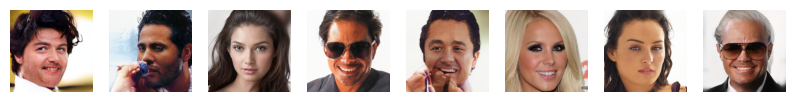

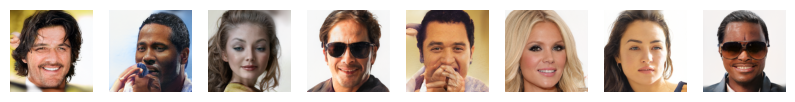

In [19]:
imgs, reconstructed_imgs = test_reconstructions(G, SAE, train_loader, h = 1, w = 8, display = True)